## Homework №2: Text classification (task 2)
*Bezhenaer OLga*

The task: 
Classify news to one of 5 categories based on text

1. Choose and argue your measure of a test's accuracy.
2. Build data processing and classification pipeline
3. Tune  your model;

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import grid_search

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#loading the data from folders and creation of the dataset
data_folder = "C:/Users/Коля/Desktop/NLP/bbc"
folders = ["business","entertainment","politics","sport","tech"]

os.chdir(data_folder)

x = []
y = []

for i in folders:
    files = os.listdir(i)
    for text_file in files:
        file_path = i + "/" +text_file
        #print ("reading file:", file_path)
        with open(file_path) as f:
            data = f.readlines()
        data = ' '.join(data)
        x.append(data)
        y.append(i)
 
data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
#print ('writing csv flie ...')
df.to_csv('../dataset.csv', index=False)

### EDA

In [3]:
df.head(10)

,news,type
0,Ad sales boost Time Warner profit\n \n Quarter...,business
1,Dollar gains on Greenspan speech\n \n The doll...,business
2,Yukos unit buyer faces loan claim\n \n The own...,business
3,High fuel prices hit BA's profits\n \n British...,business
4,Pernod takeover talk lifts Domecq\n \n Shares ...,business
5,Japan narrowly escapes recession\n \n Japan's ...,business
6,Jobs growth still slow in the US\n \n The US c...,business
7,"India calls for fair trade rules\n \n India, w...",business
8,Ethiopia's crop production up 24%\n \n Ethiopi...,business
9,Court rejects $280bn tobacco case\n \n A US go...,business


In [4]:
df['type'].value_counts() #we can say that the problem of sample inbalance is not presented 

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

In [5]:
df['type'].value_counts(normalize=True)

sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: type, dtype: float64

In [6]:
# obtaining a numeric representation of "type" colomn 
df['type_id'] = df['type'].factorize()[0]

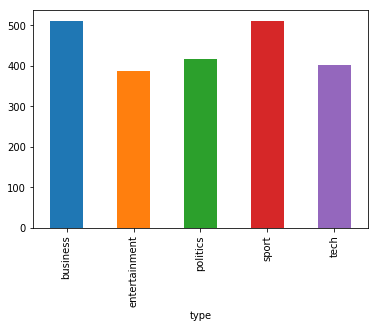

In [10]:
# data visalization 
df.groupby('type').type_id.count().plot.bar(ylim=0)


In [11]:
type_to_id = {'business':0, 'tech':1, 'politics':2, 'sport':3, 'entertainment':4}
id_to_type = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [12]:
df.head()

,news,type,type_id
0,Ad sales boost Time Warner profit\n \n Quarter...,business,0
1,Dollar gains on Greenspan speech\n \n The doll...,business,0
2,Yukos unit buyer faces loan claim\n \n The own...,business,0
3,High fuel prices hit BA's profits\n \n British...,business,0
4,Pernod takeover talk lifts Domecq\n \n Shares ...,business,0


### Text Representation

In [14]:
# extracting features from text
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.news).toarray()
labels = df.type_id
features.shape

(2225, 14454)

In [15]:
#  finding corelation between features (importantce of words) and labels(news category)
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for news, type_id in sorted(type_to_id.items()):
  features_chi2 = chi2(features, labels == type_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(news))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
. oil
. growth
. shares
  . Most correlated bigrams:
. analysts said
. economic growth
. stock market
# 'entertainment':
  . Most correlated unigrams:
. technology
. software
. users
  . Most correlated bigrams:
. anti virus
. mobile phones
. mobile phone
# 'politics':
  . Most correlated unigrams:
. blair
. election
. labour
  . Most correlated bigrams:
. prime minister
. tony blair
. mr blair
# 'sport':
  . Most correlated unigrams:
. coach
. match
. cup
  . Most correlated bigrams:
. grand slam
. australian open
. champions league
# 'tech':
  . Most correlated unigrams:
. singer
. actor
. film
  . Most correlated bigrams:
. los angeles
. film festival
. box office


### Spliting the data 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3,random_state = 123)

### Models 

In this part various models are compared in order to choose the optimal one. 
As the measure of test's accuracy f1, as it comprises both precision and recall metrics and does not suffer as "accuracy" metric from sample imbalance.

F1 'weighted'"calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall (c) sklearn documentation

In [19]:
# (Multinomial) Naive Bayes

NB_model= MultinomialNB()
NB_model.fit(X_train, y_train)
NB_pred = NB_model.predict(X_test)
print(classification_report(y_test, NB_pred))

             precision    recall  f1-score   support

          0       0.94      0.97      0.95       140
          1       1.00      0.92      0.96       124
          2       0.96      0.97      0.97       136
          3       0.99      0.99      0.99       159
          4       0.93      0.95      0.94       109

avg / total       0.96      0.96      0.96       668



In [20]:
#Logistic Regression 

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)
print(classification_report(y_test, LR_pred))

             precision    recall  f1-score   support

          0       0.96      0.95      0.96       140
          1       1.00      0.97      0.98       124
          2       0.97      0.97      0.97       136
          3       0.98      1.00      0.99       159
          4       0.93      0.95      0.94       109

avg / total       0.97      0.97      0.97       668



In [21]:
#Random Forest 

RF_model = RandomForestClassifier(n_estimators=50)
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
print(classification_report(y_test, RF_pred))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       140
          1       0.99      0.91      0.95       124
          2       0.97      0.95      0.96       136
          3       0.94      1.00      0.97       159
          4       0.98      0.92      0.95       109

avg / total       0.96      0.96      0.95       668



In [22]:
#Linear Support Vector Machine

SVC_model = LinearSVC()
SVC_model.fit(X_train, y_train)
SVC_pred = SVC_model.predict(X_test)
print(classification_report(y_test, SVC_pred))

             precision    recall  f1-score   support

          0       0.97      0.96      0.96       140
          1       1.00      0.98      0.99       124
          2       0.96      0.99      0.97       136
          3       0.99      0.99      0.99       159
          4       0.98      0.98      0.98       109

avg / total       0.98      0.98      0.98       668



#### Results:
Models performance (according to average f1 score):
- Naive Bayes f1 = 0.96
- Logistic Regression f1 = 0.97
- Random Forest f1 = 0.95
- SVC f1 = 0.98

So for tunning the models with the highest performance are chosen. (LR_model and SVC_model)

### Model tunning

In [24]:
#creation of the parameter grid for LR
param_grid_LR = {'penalty': ['l1', 'l2'],'C': [0.0001, 0.001, 0.01, 1, 100]}

# looking for best model
tunning_LR = grid_search.GridSearchCV(LR_model, param_grid_LR, scoring = 'f1_weighted', cv = 10)
tunning_LR.fit(X_train, y_train)

# checking what is the best model
tunning_LR.best_estimator_
print("BEST PARAMETERS:" ,tunning_LR.best_params_)
print("BEST SCORE:",tunning_LR.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

BEST PARAMETERS: {'C': 100, 'penalty': 'l2'}
BEST SCORE: 0.9820191557854906


In [25]:
#creation of the parameter grid for SVC 
param_grid_SVC = { 'multi_class':['ovr','crammer_singer'],'C': [0.0001, 0.001, 0.01, 1, 100]}

# looking for best model
tunning_SVC = grid_search.GridSearchCV(SVC_model, param_grid_SVC, scoring = 'f1_weighted', cv = 10)
tunning_SVC.fit(X_train, y_train)

# checking what is the best model
tunning_SVC.best_estimator_
print("BEST PARAMETERS:" ,tunning_SVC.best_params_)
print("BEST SCORE:",tunning_SVC.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

BEST PARAMETERS: {'C': 1, 'multi_class': 'crammer_singer'}
BEST SCORE: 0.9839426802467622


#### Tunning results:
The best performance ('f1_weighted'=0.0.984) Linear Support Vector Machine model shows with 'C'=1 and 'multi_class'- 'crammer_singer'. 
Also the high performance ('f1_weighted'=0.982) Logistic Regression model shows with 'C'=100 and penalty = 'l2'. 


*P.S.:in that case I do not implement Feature Selection as due to such 'good' dataset models shows quite high performance.*